# Einleitung zum Versuch "Calibration Correction"

In diesem Versuch liegt der Schwerpunkt auf der Kalibrierung von CO₂ Sensoren. Diese Sensoren liefern häufig Messwerte, die durch Offsets verfälscht sind. Eine präzise Kalibrierung ist daher unerlässlich, um zuverlässige und wissenschaftlich verwertbare Ergebnisse zu erhalten.

## Hintergrund und Motivation

Sensoren sind in der Praxis oft verschiedenen Störeinflüssen ausgesetzt, die ihre Messgenauigkeit beeinträchtigen können. Ohne entsprechende Korrekturen können die erfassten Daten zu Fehlinterpretationen führen. In unserem Versuch wird deshalb zunächst eine einfache 1-Punkt-Kalibrierung durchgeführt, um den systematischen Offset zu ermitteln. Anschließend erfolgt eine 2-Punkt-Kalibrierung, bei der sowohl der Slope und der Intercept bestimmt werden. Diese Methode ermöglicht es, Messwerte über den gesamten Dynamikbereich des Sensors korrekt zu adjustieren.

In [4]:
import polars as pl
import os
import sys

# Add the parent directory to the system path
PROJECT_PATH = os.path.abspath(os.path.join(".."))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from utils.plot_dataframes import plot_column, plot_columns, plot_column_difference
from utils.process_bottles import trim_rows, median_and_mean

In [5]:
df_p = pl.read_parquet("../data/1_Calibration_Correction/Reference_Picarro_G2401.parquet")
df_s = pl.read_parquet("../data/1_Calibration_Correction/Sensor_GMP343_Measurement.parquet")
df_c = pl.read_parquet("../data/1_Calibration_Correction/Sensor_GMP343_Calibration.parquet")

In [6]:
df = df_s.join(df_p, on="datetime", how="left")

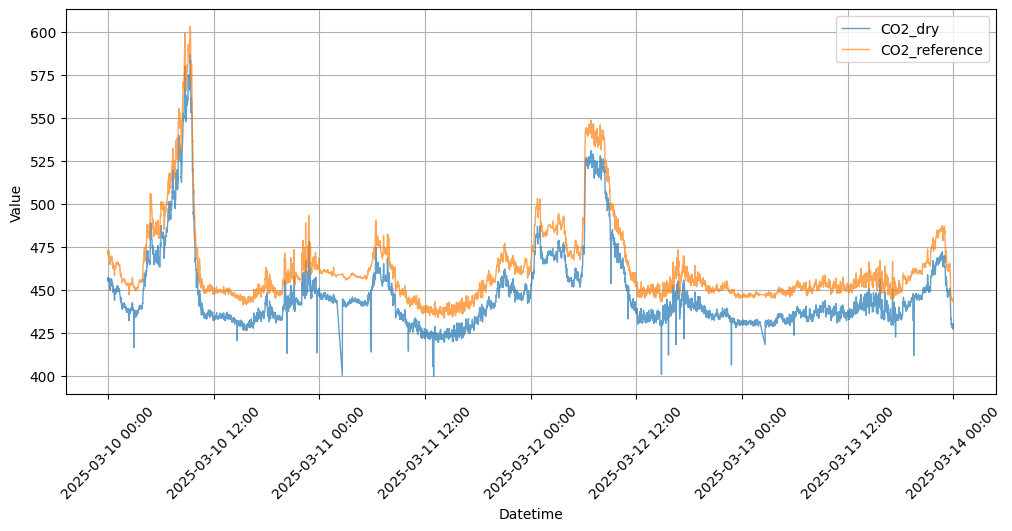

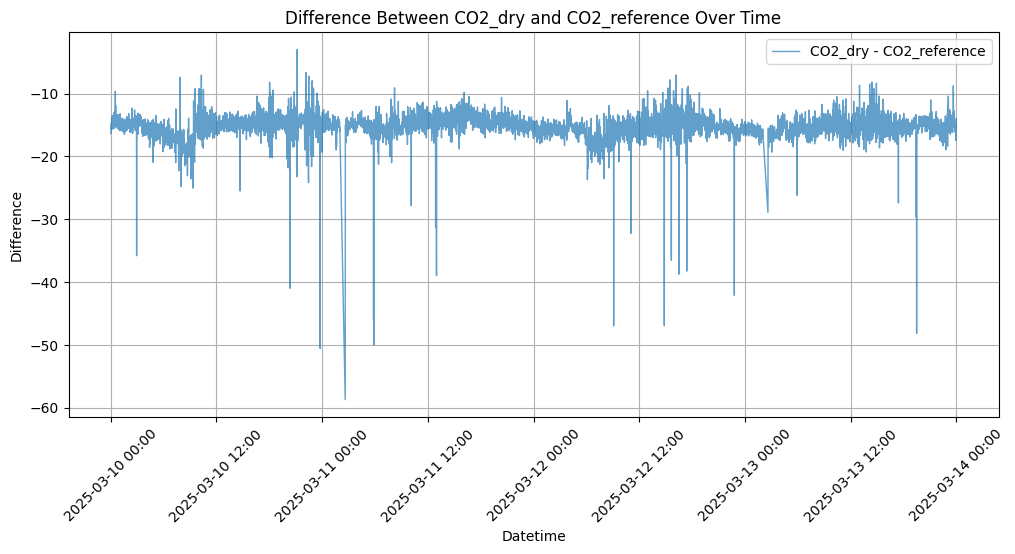

In [7]:
plot_columns(df,"datetime",["CO2_dry", "CO2_reference"])
plot_column_difference(df,"datetime",["CO2_dry", "CO2_reference"])

---

## Erklärung zu Ausreißern in Bild 2

Die starken Ausreißer (10 ppm und mehr) in Bild 2 werden durch Power Resets des CO2 Sensors verursacht. Diese Resets sind notwendig, wenn der Sensor sich in einem Zustand befindet, der eine korrekte Messung nicht mehr zulässt. In solchen Fällen wird der Sensor zurückgesetzt, um ihn wieder in einen betriebsbereiten Zustand zu versetzen. Beim Aufstart sendet der Sensor kurzeitig falsche Messungen. Im Notebook 2 werden wir eine Methode kennenlernnen, um diese Ausreißer zu identifizieren und zu entfernen. Bis dahin werden wird die Ausreißer in Bild 2 nicht weiter beachten. Wir konzentrieren uns zunächst auf die Kalibrierung des Sensors, sodass die Unterschied zwischen Sensor und Referenzmessung möglichst nahe 0 sind. 

---

# Offset-Korrektur

Die Offset-Korrektur ist eine grundlegende Methode, um konstante Messabweichungen zu korrigieren – insbesondere, wenn die CO₂-Werte nahe dem Basiswert liegen. Dabei wird ein fester Fehlerwert, der sogenannte Offset, von den Messwerten abgezogen, um den tatsächlichen CO₂-Gehalt zu ermitteln.

## Grundlagen der Offset-Korrektur

Bei der Offset-Korrektur wird angenommen, dass der Sensor einen konstanten Fehler aufweist. Die Korrektur erfolgt, indem der Offset von allen gemessenen Werten subtrahiert wird. Die grundlegende Formel lautet:

$$
\text{Korrigierter Wert} = \text{Gemessener Wert} - \text{Offset}
$$

Der Offset wird dabei typischerweise durch Messungen gegen eine Referenz bestimmt.

## Experimentelle Vorgehensweise

Bevor komplexere Kalibrierverfahren angewendet werden, experimentiert bitte selbstständig mit der Offset-Korrektur. Ziel ist es, ein fundiertes Verständnis dafür zu entwickeln, wie der Offset die Messwerte beeinflusst und warum er korrigiert werden muss:

**Anwendung der Offset-Korrektur:**
   - Subtrahiert den ermittelten Offset von allen zukünftigen Messwerten.
   - Beobachtet, wie sich die korrigierten Werte im Vergleich zu den erwarteten Werten verhalten.

# 🧪 Praktiksche Übung 1

In dieser Übung wollen wir ein Gefühl für den Offset entwickeln, indem wir diesen Stück für Stück anpassen, um eine passende Korrektur für unsere Sensordaten zu erhalten.

✅ Aufgabe:

- Verändere den Parameter `offset`, bis eine gute Korrektur der Daten sichtbar wird. 

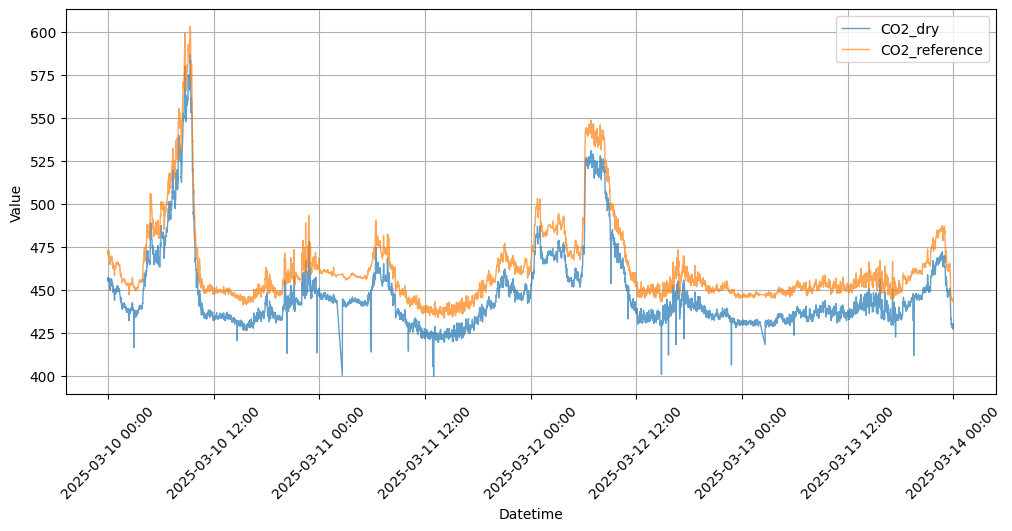

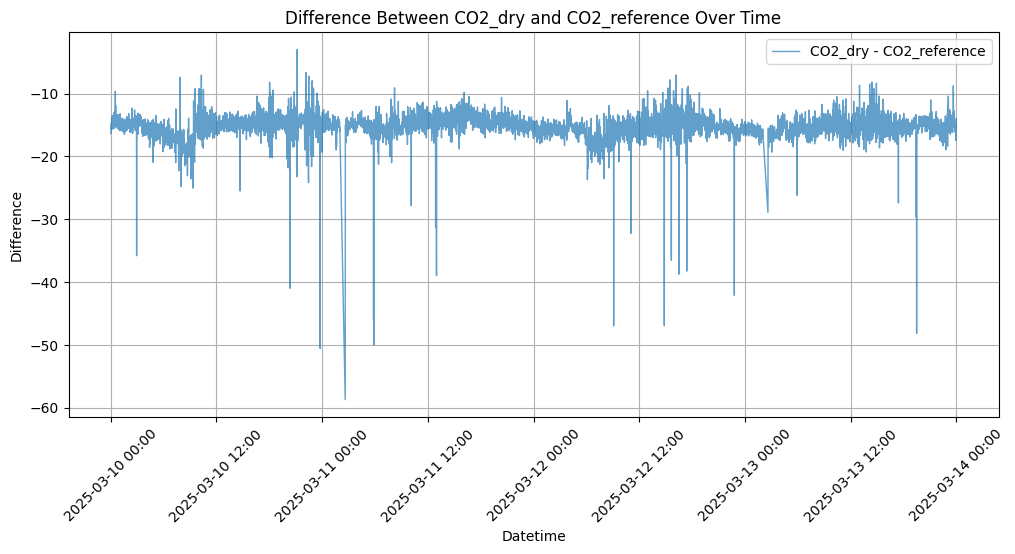

In [9]:
## Verändere nachfolgende Parameter
offset = 0
##

df_plot = df.with_columns(pl.col("CO2_dry") - offset)

plot_columns(df_plot,"datetime",["CO2_dry", "CO2_reference"])
plot_column_difference(df_plot,"datetime",["CO2_dry", "CO2_reference"])

## Fragen:

- Welchen Offset habt ihr final ausgewählt? 
  
- Wieso habt ihr diesen Offset ausgewählt?

- Wieso funktioniert die Korrektur an manchen Zeitpunkten besser und an anderen schlechter?


---

# Umstellung von Offset-Korrektur zur Zweipunktkalibrierung

Wir wechseln von der einfachen Offset-Korrektur zur Zweipunktkalibrierung. Wie ihr zuvor gesehen habt, passt die Offset-Korrektur an manchen Stellen gut (Wertebereich: 425-450ppm), an anderen (Wertebereich: 500-600ppm) jedoch nicht. Dies liegt daran, dass die Offset-Korrektur nur einen konstanten Fehler berücksichtigt. Bei höheren CO₂-Werten zeigt sich, dass der Sensor mit einem anderen Offset korregiert werden muss. Daher ist eine einfache Offset-Korrektur nicht ausreichend.

## Warum die Umstellung?

Bisher haben wir eine Offset-Korrektur angewendet, die den Sensorfehler durch eine konstante Verschiebung kompensiert. Diese Methode ist dann effektiv, wenn die CO₂-Werte nahe am Basiswert liegen. Steigen die Werte jedoch deutlich an, wird sichtbar, dass der Sensor nicht nur einen konstanten Fehler aufweist, sondern auch in seiner Skalierung abweicht. Die einfache Offset-Korrektur berücksichtigt diese Skalierungsproblematik nicht, was zu Ungenauigkeiten führt.

## Korrekturfunktion

Wir gehen davon aus, dass diese Fehler über den betrachteten Wertebereich linear sind. Das bedeutet, dass der Offset sich linear mit dem CO₂-Gehalt ändert. Die Korrektur erfolgt durch eine Geradenfunktion (y = mx + b). 

## Funktionsweise der Zweipunktkalibrierung

Die Zweipunktkalibrierung bestimmt den Offset an zwei Punkten, um die zwei unbekannten Parameter **$m$** (Slope) und **$b$** (Intercept) ermitteln zu können. Klassischerweise werden die Punkte an beiden Enden des Messbereichs gewählt, um eine möglichst präzise Kalibrierung zu gewährleisten. Hier wäre dies z.B. bei etwa 400 ppm und 600 ppm.

- **Low Value:** Ein bekannter Wert, leicht unterhalb des Messbereichs
- **High Value:** Ein zweiter Wert, leicht oberhalb des Messbereichs

Aus diesen beiden Referenzwerten lässt sich eine lineare Kalibrierungsgleichung ableiten:

$$
\text{Korrigierter Wert} = m \times (\text{Gemessener Wert}) + b
$$

wobei:
- **$m$** den Skalierungsfaktor (Steigung) darstellt,
- **$b$** den zu korrigierenden Offset bei 0 ppm (y-Achsenabschnitt) beschreibt.

## Experimentelle Vorgehensweise

Bevor Kalibrierflaschen zur Bestimmung der Parameter eingesetzt werden, experimentiert bitte selbstständig mit den Werten für **$m$** (Slope) und **$b$** (Intercept). Ziel ist es, ein Gefühl  darüber zu entwickeln, wie groß diese Parameter etwa sein müssen, um eine gute Kalibrierung zu erreichen.

1. **Verständnis der Parameter:**
   - **Slope ($m$):** Dieser Faktor bestimmt, wie stark sich der gemessene Wert in Relation zur tatsächlichen CO₂-Konzentration verändert. Ein zu geringer Slope führt dazu, dass hohe Konzentrationen nicht ausreichend abgebildet werden, während ein zu hoher Slope die Änderungen überbetont.
   - **Intercept ($b$):** Dieser Parameter korrigiert die Basisverschiebung des Sensors. Ein falsch eingestellter Intercept bewirkt, dass die Messwerte dauerhaft nach oben oder unten verschoben sind, selbst wenn die Skalierung stimmt.

2. **Eigene Experimente durchführen:**
   - Variiert **$m$** und **$b$** an euren Messdaten und beobachtet, wie sich die Kalibrierung verändert.
   - Vergleicht eure Ergebnisse mit den bekannten Referenzwerten und versucht herauszufinden, welche Kombination am besten passt.


# Visualisierung

Hier ist die zeitliche Information entfernt und die Messwerte nach x aufsteigend sortiert dargestellt. Die blaue Linie sind die rohen Messwerte gemessen durch den Sensor, die braune Linie die Messwerte nach der Korrektur.
Ihr seht, dass abhängig von der Größe des Wertes X, die Korrektur unterschiedlich stark ausfällt (blaue Pfeile). 

<img src="../pictures/2pt_calibration_fct.jpg" alt="2pt calibration" width="600"/>

Source: https://www.dracal.com/wp-content/uploads/2022/06/2pt_calibration_fct.png


# 🧪 Praktiksche Übung 2

In dieser Übung wollen wir ein Gefühl für die Parameter Intercept und Slope entwickeln, indem wir diese Stück für Stück anpassen, um eine passende Korrektur für unsere Sensordaten zu erhalten.

✅ Aufgabe:

- Verändere die Parameter `intercept` und `slope`, bis eine gute Korrektur der Daten sichtbar wird. 

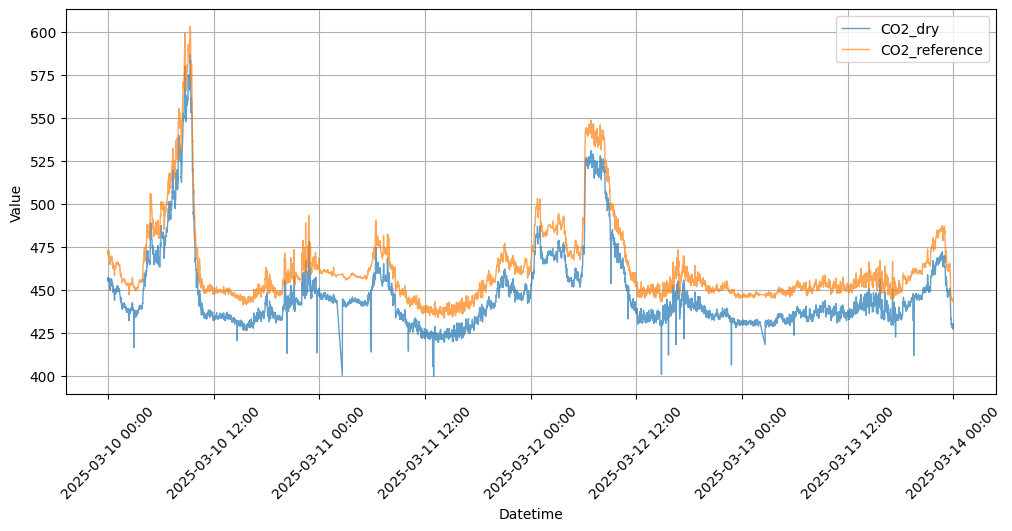

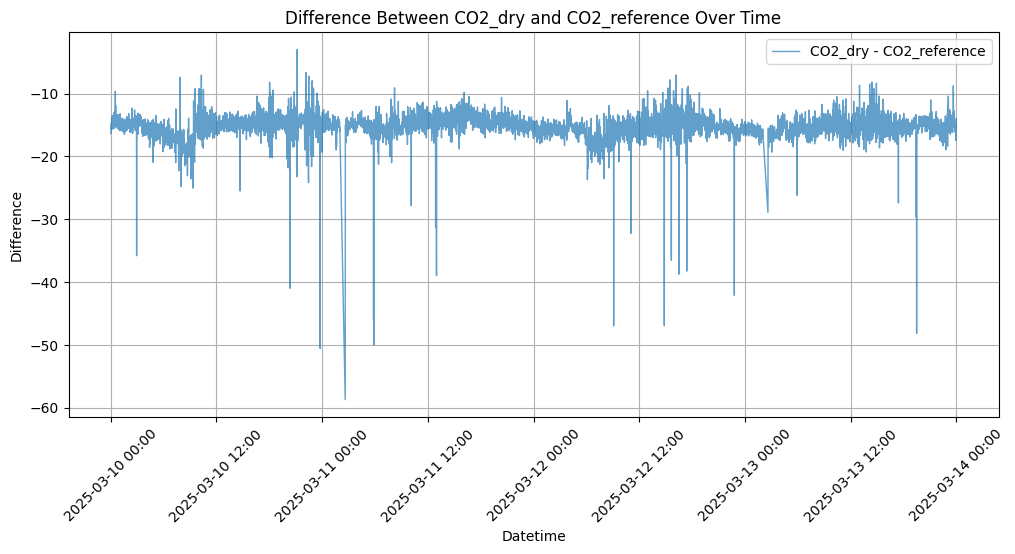

In [11]:
## Verändere nachfolgende Parameter
intercept = 0
slope = 1
##

df_plot = df.with_columns(pl.col("CO2_dry") * slope + intercept)

plot_columns(df_plot,"datetime",["CO2_dry", "CO2_reference"])
plot_column_difference(df_plot,"datetime",["CO2_dry", "CO2_reference"])

In [ ]:
# Betrachtet nun die Differenz "diff" zwischen den beiden Sensoren. Habt ihr die Korrektur gut getroffen?
print(df_plot.with_columns(diff = pl.col("CO2_dry") - pl.col("CO2_reference")).select(pl.col("diff")).describe())

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ diff       │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 5691.0     │
│ null_count ┆ 0.0        │
│ mean       ┆ -15.285223 │
│ std        ┆ 2.278631   │
│ min        ┆ -58.730373 │
│ 25%        ┆ -16.101266 │
│ 50%        ┆ -15.169193 │
│ 75%        ┆ -14.271651 │
│ max        ┆ -2.974747  │
└────────────┴────────────┘


Fragen:

- Welchen Slope und Intercept habt ihr ausgewählt?

- Was ist eine gute Taktik um den Slope und Intercept schnell bestimmen zu können?

# Bestimmung anhand von Kalibrierflaschen

Nachfolgend seht ihr einen Kalibriervorgang mit Kalibrierflaschen. Diese sind mit tockener Luft und einer bekannten CO₂-Konzentration gefüllt und dienen dazu, den Sensor präzise zu kalibrieren.

Der Kalibrierprozess erfolgt sequentiell, wobei die erste Kalibrierflasche länger aktiv ist. Die Kalibrierflaschen werden über elektronische Magnetventil zugeschalten, während der Hauptkanal geschlossen wird. Um Gas von den Kalibrierflaschen zu entnehmen, muss ein Unterdruck durch die Pumpe angelegt werden.

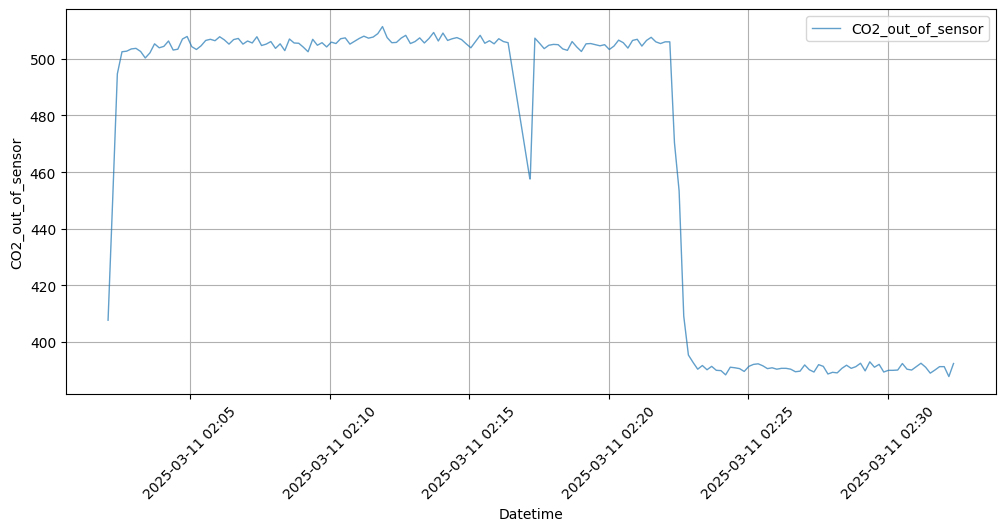

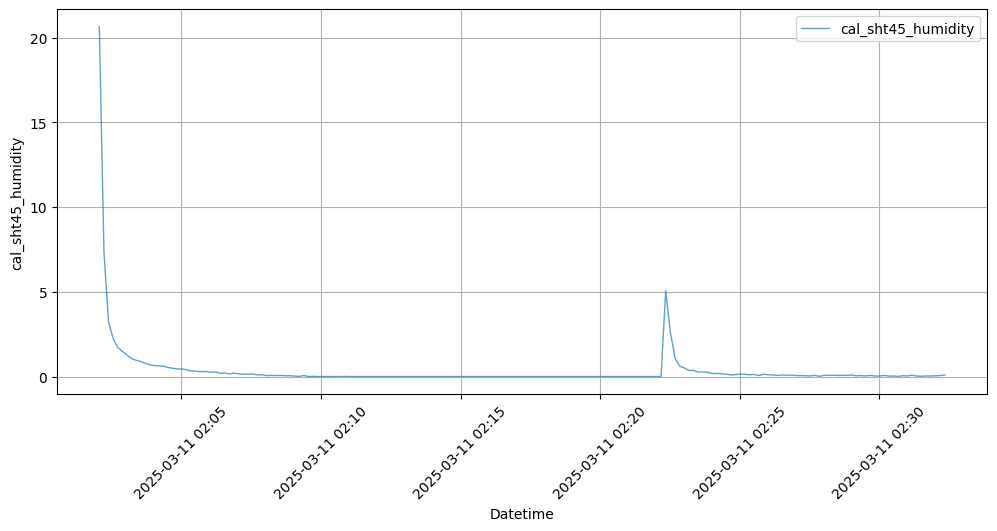

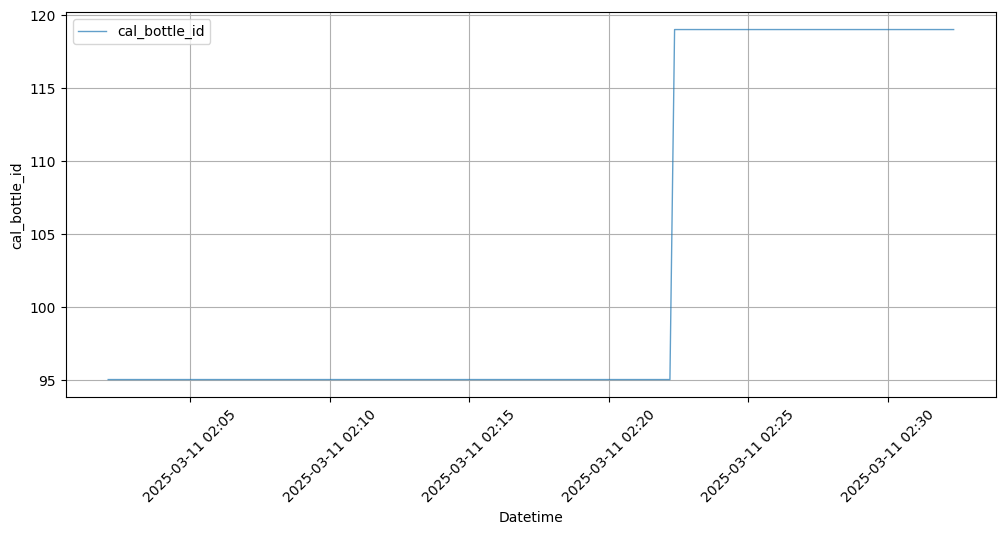

In [7]:
plot_column(df_c,"datetime","CO2_out_of_sensor")
plot_column(df_c,"datetime","cal_sht45_humidity")
plot_column(df_c,"datetime","cal_bottle_id")

Fragen

- Was seht ihr auf den Graphen?

- Was für einen Hintergrund hat die Veränderung der relativen Luftfeuchtigkeit?

- Wie kann man sich das im realen System vorstellen?

# 🧪 Praktiksche Übung 3

In dieser Übung arbeiten wir mit Daten, die während einer Kalibrierung aufgenommen wurden. Ziel ist es Parameter zu finden, die eine stabile Auswertung beider Messungen zu erhalten und das initiale Trocknen des Luftkanals zuverlässig zu entfernen.

✅ Aufgabe:

- Ermittle den Mean und den Median für die Kalbrationen mit den Kalibrierflaschen 119 und 95 
- Verändere die Parameter `cut_from_start` und `cut_from_end`, um die Trocknung des Luftkanals stabil zu entfernen

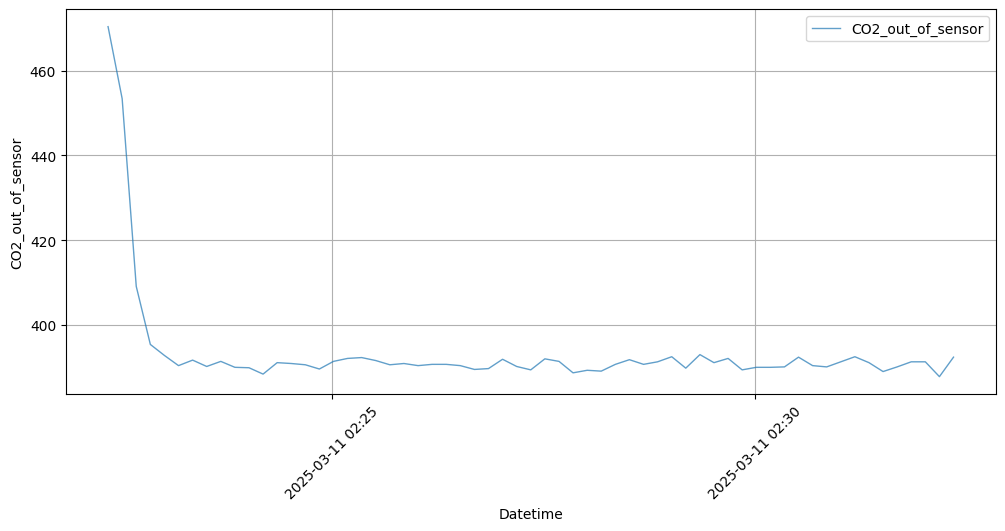

In [8]:
## Verändere nachfolgende Parameter
bottle_id = 119 # 119 or 95
##

df_bottle = df_c.filter(pl.col("cal_bottle_id") == bottle_id)

plot_column(df_bottle,"datetime","CO2_out_of_sensor")

Median: 390.7, Mean: 393.43934426229504


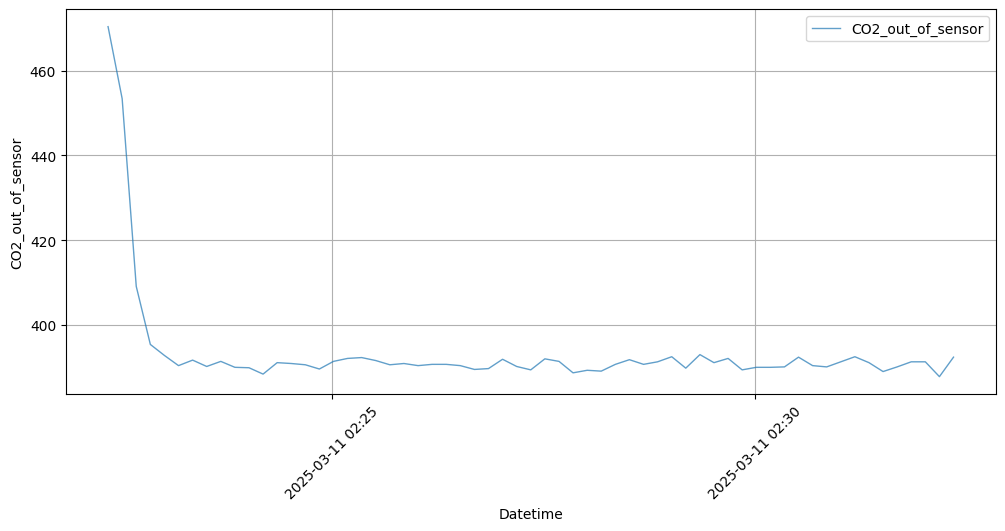

In [49]:
## Verändere nachfolgende Parameter
cut_from_start = 0 #Percent
cut_from_end = 0 #Percent
##

df_bottle_trimmed = trim_rows(df_bottle, cut_from_start, cut_from_end)

median, mean = median_and_mean(df_bottle_trimmed, "CO2_out_of_sensor")
print(f"Median: {median}, Mean: {mean}")

plot_column(df_bottle_trimmed,"datetime", "CO2_out_of_sensor")

Fragen

- Was ist stabiler der Median oder der Mean? Wieso ist das der Fall?

- Welchen Wert hat der Sensor für die Flasche 95 und 119 gemessen?

- Wieso ist es sinnvoll hier die Kalibrierdauer zu beschneiden?

---

# Kalibrierung der CO₂-Messungen aus Medianwerten

In dieser Übung verwendet ihr zwei Kalibrierflaschen, um zuerst den Offset mittels einer 1-Punkt-Kalibrierung zu bestimmen und anschließend den Slope sowie den Intercept über eine 2-Punkt-Kalibrierung zu berechnen.

## Referenzwerte

- **Kalibrierflasche 119:** Tatsächlicher CO₂-Wert = 403.04 ppm  
- **Kalibrierflasche 95:** Tatsächlicher CO₂-Wert = 522.34 ppm



## 1-Punkt-Kalibrierung: Bestimmung des Offsets

Zunächst wird der Offset an einem einzelnen Referenzpunkt ermittelt. Hierbei verwendet ihr den Median der Messungen mit jeweils einer der Kalibrierflaschen.

Die Berechnung erfolgt nach der Formel:

$$
\text{Offset} = \text{Gemessener Median} - \text{Tatsächlicher Wert}
$$




## 2-Punkt-Kalibrierung: Berechnung von Slope und Intercept

Für eine genauere Kalibrierung nutzt ihr beide Referenzflaschen. Ihr bestimmt den Median der Messwerte für jede Flasche:

- $M_{95}$ bezeichnet den Median der Messungen an **Kalibrierflasche 95**.
- $M_{119}$ bezeichnet den Median der Messungen an **Kalibrierflasche 119**.

Unter der Annahme eines linearen Verhaltens der CO₂ Sensors zwischen den gemessenen Median Werten und dem tatsächlichen CO₂-Wert gilt:

$$
\text{Tatsächlicher Wert} = m \times (\text{Gemessener Median}) + b
$$

Daraus ergeben sich für die beiden Kalibrierflaschen die Gleichungen:

$$
522.34 = m \cdot M_{95} + b
$$

$$
403.04 = m \cdot M_{119} + b
$$

### Berechnung des Slopes \( m \)

Um \( m \) zu ermitteln, subtrahiert ihr die Gleichung für **Kalibrierflasche 119** von der Gleichung für **Kalibrierflasche 95**:

$$
522.34 - 403.04 = m \cdot \left( M_{95} - M_{119} \right)
$$

Das vereinfacht sich zu:

$$
m = \frac{119.30}{M_{95} - M_{119}}
$$

### Berechnung des Intercepts \( b \)

Nachdem \( m \) bekannt ist, kann \( b \) aus einer der beiden Gleichungen berechnet werden, beispielsweise:

$$
b = 522.34 - m \cdot M_{95}
$$

# 🧪 Praktische Übung 4

✅ Aufgabe:

- Berechnet die Offsets für die 1-Punkt Kalbrierung
- Berechnet den Slope und Intercept für die 2-Punkt Kalbrierung

In [50]:
#Beispiel Python Berechnung

(100 + 50) / 2

75.0

In [51]:
# Berechnung: Offset 119 (1-Punkt Kalibrierung)

In [52]:
# Berechnung: Offset 95 (1-Punkt Kalibrierung)

In [53]:
# Berechnung: Slope (2-Punkt Kalibrierung)

In [54]:
# Berechnung: Intercept (2-Punkt Kalibrierung)

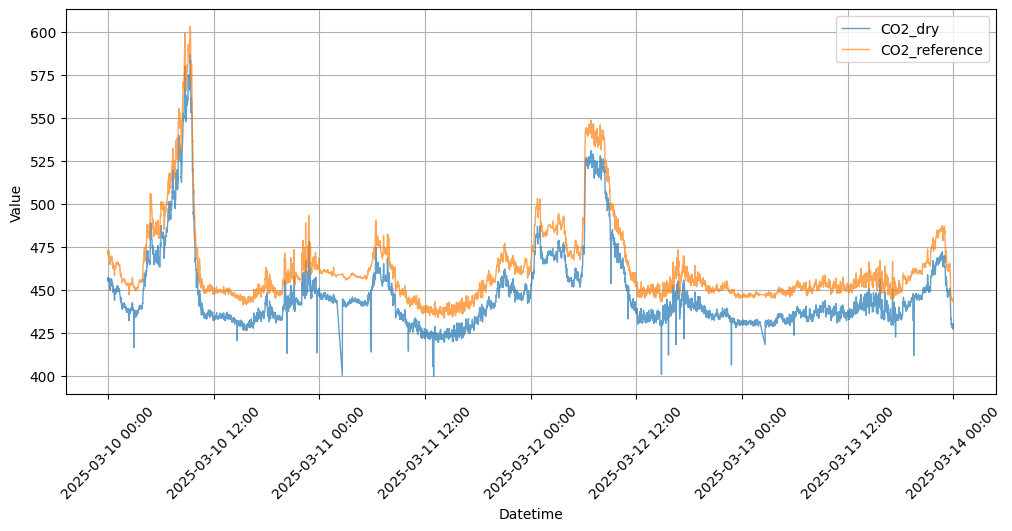

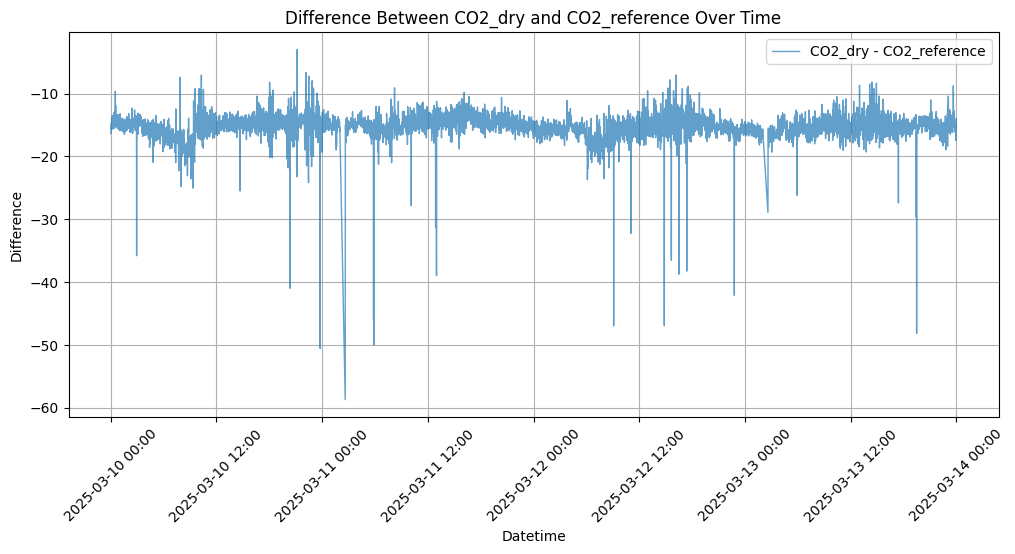

In [9]:
## Verändere nachfolgende Parameter
intercept = 0.0
slope =  1.0
##

df_plot = df.with_columns(pl.col("CO2_dry" ) * slope + intercept)

plot_columns(df_plot,"datetime",["CO2_dry" , "CO2_reference"])
plot_column_difference(df_plot,"datetime",["CO2_dry", "CO2_reference"])

Fragen:

- An welchen Tag wurde die Kalibrierung durchgeführt?

- Wie representativ ist die Kalibrierung für die gesamte Zeitdauer?

- Erwartet ihr, dass die Korrekturfaktoren für die Kalibrierung über längere Zeit stabil bleiben? 

- Was versteht man unter Sensor Drift?